<div style="text-align: center; font-weight: bold; font-size: 300%">PC 8 - MAP412</div>                                                        <br />      
<div style="text-align: center; font-size: 150%">École Polytechnique, MAP412 - Novembre 2019</div><br />  
<div style="text-align: center; font-size: 120%">Paul Calot--Plaetevoet</div>

# Résolution de systèmes linéaires par des méthodes de gradient

In [1]:
import numpy as np

from scipy.sparse.linalg import eigs, norm
from scipy.sparse import csc_matrix,csr_matrix
from matplotlib import pyplot as plt

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row,column

output_notebook(hide_banner=True)

from time import time, sleep

In [2]:
def show_level_set(a, b, xk, xexa, nlevel=8):
    """
    Trace les lignes de niveaux f(x) pour x = xk[0:nlevel] les premiers itérés d'une méthode de gradient
    pour un système (2x2)
    
    ----------
    a : ndarray (matrice du système) 
    b : ndarray (second membre du système)
    xk : ndarray (itérés de la méthode de gradient)
    xexa : ndarray (solution exacte)
    nlevel : nombre de lignes de niveaux correspondant au nlevel premiers itérés xk
    """
    
    # petite modification
    print("la convergence a lieu en ",len(xk),"itérations vers ",xk[-1],".")
    
    def f(a, b, x1, x2):
        return 0.5*((a[0,0]*x1+a[0,1]*x2)*x1 + (a[1,0]*x1+a[1,1]*x2)*x2) - b[0]*x1 - b[1]*x2

    x1 = np.linspace(-0.5, 1., 200)
    x2 = np.linspace(-2.5, 0.5, 200)
    x1, x2 = np.meshgrid(x1, x2)

    z = f(a, b, x1, x2)

    level =  f(a, b, xk[0:nlevel,0], xk[0:nlevel,1])

    plt.figure(figsize=(7.5,15))
    plt.contour(x1, x2, z, np.flip(level))
    plt.plot(xk[0:nlevel,0], xk[0:nlevel,1], '--ro')
    plt.scatter(xexa[0], xexa[1])
    plt.show()

In [3]:
# Fonctions utilisée pour résoudre l'exemple deux:

def sol_analytique(x): # définition de la solution analytique
    return( -x*(1-x*x*x*x)/20)

def X(N): # définition du vecteur b de l'exemple 2
    Xv=np.zeros(N)
    h=1/(N+1)
    Xv[0]=h
    for k in range(1,N):
        Xv[k]=h+Xv[k-1]
    return Xv # renvoie sous la forme d'un vecteur ligne !!


# stockage creux:
def CSC_A(N):
    p=(N+1)*(N+1)
    L=np.zeros((3,3*N-2)) # 3N-2 le nombre de coefficient à stocker
    
    for k in range(N): # diagonale du milieu
        L[0][k]=k # ligne
        L[1][k]=k # colonne
        L[2][k]=-2*p
        
    for k in range(N-1): # diagonale supérieure
        L[0][N+k]=k # ligne 
        L[1][N+k]=k+1 # colonne
        L[2][N+k]=p
        
    for k in range(N-1): # diagonale inférieure 
        L[0][2*N-1+k]=k+1 # ligne
        L[1][2*N-1+k]=k # colonne
        L[2][2*N-1+k]=p
        
    return csc_matrix((L[2],(L[0],L[1])),[N,N])

In [4]:
# fonction utilisée pour afficher les résultats sur l'exmple 2

def show_results2(norme_a,xk,xexa,leg="center_right",power_conv=1,rg_erreur=0):
    """
        norme_a (int): norme 2 de la matrice a
        xk (ndarray): suite des itérés
        xexa (ndarray): solution exacte
        power_conv (int): inverse de la puissance sur le conditionnement de a dans le taux de convergence.
        rg_erreur (int): rang d'itération à partir du quel nous représentons l'erreur en fonction du nombre d'itérations.
                        En le faisant varier on peut ainsi s'assurer que le taux de convergence pratique est majoré par la borne théorique de l'exerice.
        """
    n=len(xk)
    rhoA=(norme_a**(1/power_conv)-1)/(norme_a**(1/power_conv)+1)
    print("La borne théorique du taux de convergence est environ: ", round(rhoA,5))
    print("")
    print("la convergence a lieu en ",len(xk),"itérations vers ",xk[-1],".")
    
    # Tracé
    Nt=np.linspace(0,n,n)
    err=np.array([np.linalg.norm(xexa-xk[k]) for k in range(n)])
    
    print("")
    print("L'erreur finale est: ",err[-1],".")
    
    
    # Tracé de l'erreur au rang k+1 en fonction de l'erreur au rang k
    fig = figure(width=800, height=400,title="Erreur au rang k+1 en fonction de l'erreur au rang k")
    fig.line(err[:n-1],err[1:n],line_width=1,color="blue",legend="Erreur au rang k+1 en fonction de celle au rang k")
    fig.line(err,err,line_width=1,color="red",legend="y=x")
    fig.xaxis.axis_label = "Erreur au rang k"
    fig.yaxis.axis_label = "Erreur au rang k+1"        
    fig.legend.location = "top_left"


        # Tracé de l'erreur en fonction du nombre d'itérations.
    if rg_erreur>n:
        rg_erreur=0
        print("rg_erreur est supérieur au nombre d'itérations")
        
    Ytilde=np.zeros(n-rg_erreur)
    Ytilde[0]=err[rg_erreur]
    for k in range(0,n-rg_erreur-1):
        Ytilde[k+1]=Ytilde[k]*rhoA

    fig1 = figure(width=800, height=400,title="Erreur en fonction du nombre d'itérations.")
    fig1.line(Nt[rg_erreur:],err[rg_erreur:],line_width=1,legend="Erreur pratique")
    fig1.line(Nt[rg_erreur:],Ytilde,line_width=1,color="red",legend="Erreur - décroissance majorante")
    fig1.xaxis.axis_label = "Nombre d'itérations"
    fig1.yaxis.axis_label = "Erreur au rang k"
    fig1.legend.location = leg
    
    show(row(fig,fig1))
    
 # on renvoie également les caractéristiques pour plus tard
    
    return (n,err[-1],np.exp(np.log(err[-1]/err[0])/n))
    

## Exemples de la PC

### Remarques: je définis une liste qui contiendra un certain nombre d'information concernant le deuxième exemple afin d'en faire une synthèse à la fin.

In [5]:
carac=[]

### Exemple 1

On considère un système $2\times 2$ pour lequel on pourra facilement visualiser le comportement des algorithmes :

\begin{equation*}
A=\begin{pmatrix}
7 & 0 \\
0 & 1
\end{pmatrix},\qquad b=\begin{pmatrix}
2 \\ -1
\end{pmatrix}
\end{equation*}


In [6]:
# définition des constantes utilisées dans les trois méthodes pour l'exemple 1:

a1_int=np.array([[7,0],[0,1]])
a1=csc_matrix(a1_int)
b1=np.array([2,-1])
alpha1=1/4 # le meilleur pas est 1/(val_propre1 + val_propre2) qui se lisent sur la diagonale de A.
xexa1=np.array([2/7,-1]) # solution théorique

### Exemple 2

Un système de taille $N\times N$ (déjà étudié lors de la PC 6) qui correspond à une discrétisation du laplacien 1D, et sur lequel on pourra mettre à profit la structure creuse de $A$ :

\begin{equation*}
A =
\begin{pmatrix}
2/h^2    & -1/h    & 0       &\dots   & 0 \\
-1/h    & 2/h^2    & -1/h     & \ddots& \vdots  \\
0      & \ddots & \ddots &\ddots  &0\\
\vdots & \ddots & \ddots &\ddots  & -1/h\\
0      & \dots  &  0   &   -1/h  & 2/h^2
\end{pmatrix},
\qquad b =
\renewcommand{\arraystretch}{1.2}
\begin{pmatrix}
h^3 \\ (2h)^3 \\ \vdots \\ ((N-1)h)^3 \\ (Nh)^3
\end{pmatrix}, \qquad h=\frac{1}{N+1}.
\end{equation*}

In [7]:
# définition de quelques constantes utilisée dans la suite:

     # pour N=64
N1=64
Xx1=X(N1)
b21=Xx1**3
xexa21=sol_analytique(Xx1)
# On exploite le stockage creux:
a21=CSC_A(N1)
norme_a1=norm(a21)

    # pour N=4

N2=4
Xx2=X(N2)
b22=Xx2**3
xexa22=sol_analytique(Xx2)
# On exploite le stockage creux:
a22=CSC_A(N2)
norme_a2=norm(a22)

In [20]:
print(a22.toarray())

[[-50.  25.   0.   0.]
 [ 25. -50.  25.   0.]
 [  0.  25. -50.  25.]
 [  0.   0.  25. -50.]]


## Gradient à pas fixe

**Ecrire une fonction qui implémente l'algorithme du gradient à pas fixe en prenant comme argument la matrice A, le vecteur b, le pas, le nombre maximal d'itérations, une tolérance sur l'erreur et retournant le tableau d'itérés de la méthode.**

In [8]:
# pourquoi ne pas lui donner également x0? Ici on suppose que x0=0
def fixed_step_gradient(a, b, alpha, nit_max=10000, eps=1.e-6):
    
    # initialisations
    xk=[] # tableau d'itérés
    k=0
    n=len(b)
    x=np.zeros(n)
    err=eps+1 # erreur
    
    while (k<nit_max and err>eps):
        # calcul de xk+1
        ax=a.dot(x)
        Grad=ax-b
        
        # xk+1
        x=x-alpha*Grad
        
        # ajout de xk+1
        xk.append(x) 
        
        # itération de l'erreur et de k
        k=k+1
        err=np.linalg.norm(Grad)
       
    return np.array(xk)

### Exemple 1

**Utiliser l'algorithme du gradient à pas fixe pour résoudre le système de l'exemple 1. Tracer les lignes de niveaux de la fonction $f$, ainsi que les différents itérés obtenus. Montrer que l'on peut obtenir différents comportements en fonction du choix de $\alpha$.**

on a chosi alpha=  0.25  .
la convergence a lieu en  52 itérations vers  [ 0.28571419 -0.99999968] .


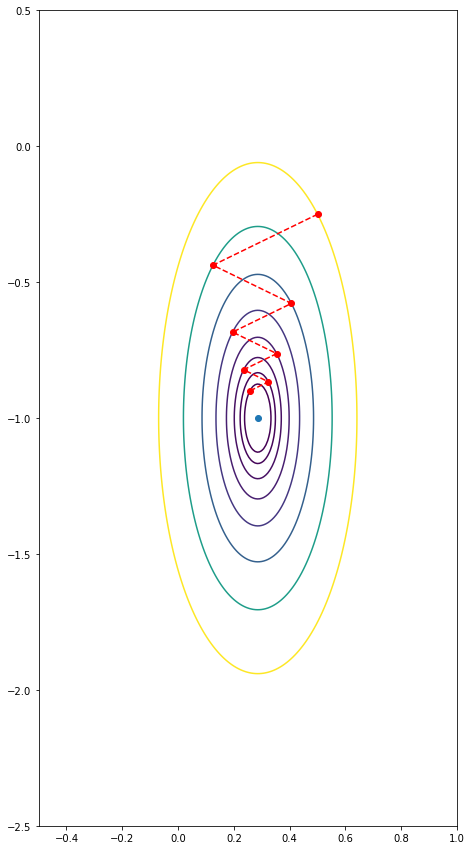

on a choisi alpha=  0.28  .
la convergence a lieu en  357 itérations vers  [ 0.28571442 -1.        ] .


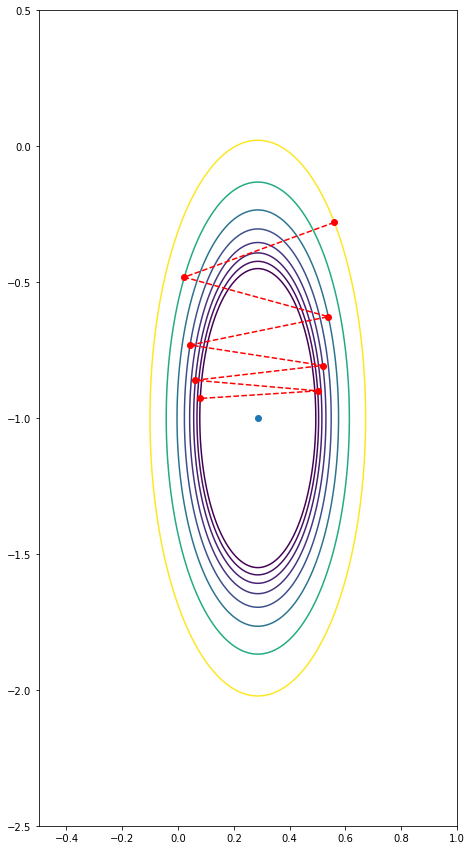

on a choisi alpha=  0.19  .
la convergence a lieu en  67 itérations vers  [ 0.28571429 -0.99999926] .


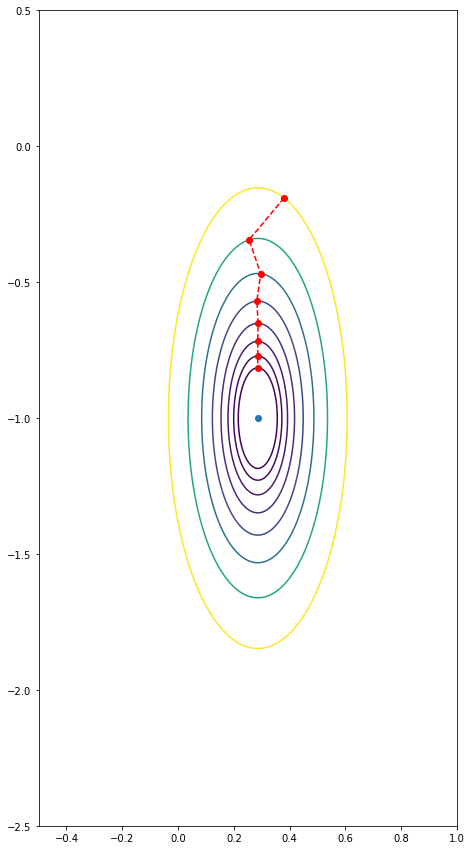

In [25]:
xk=fixed_step_gradient(a1,b1,alpha1) 
print("on a chosi alpha= ",alpha1," .")
show_level_set(a1, b1, xk, xexa1,nlevel=8)

alpha12=0.28
xk=fixed_step_gradient(a1,b1,alpha12) 
print("on a choisi alpha= ",alpha12," .")
show_level_set(a1, b1, xk, xexa1,nlevel=8)


alpha13=0.19
xk=fixed_step_gradient(a1,b1,alpha13) 
print("on a choisi alpha= ",alpha13," .")
show_level_set(a1, b1, xk, xexa1,nlevel=8)

On voit qu'en ne changeant que très légèrement $\alpha$ (de l'ordre de 8%), on double le nombre d'itérations nécessaires avant de converger. On converge en 52 itérations avec le pas fixe.

### Exemple 2

**Utiliser l'algorithme du gradient à pas fixe pour résoudre le système de l'exemple 2 avec $N=4$, puis $N=64$, en utilisant le pas $\alpha$ optimal obtenu à la question précédente. On pourra calculer numériquement la plus petite et la plus grande valeur propre de $A$ à l'aide de la fonction *scipy.sparse.linalg.eigs*. Observer le taux de convergence, et comparer avec la majoration théorique. On pourra afficher l'erreur après l'itération $k+1$ en fonction de l'erreur après l'itération $k$. Observer également la solution obtenue après $10^3$ itérations, et l'erreur avec la solution théorique. Commenter.**

In [10]:
# calcul du meilleur alpha, N définit plus tôt 

def best_alpha(a): # pour le gradient à pas constant
    try:
        val_propres=eigs(a)[0].real # pour n'avoir que les valeurs propres (pas les vect. propres) et les avoir en réel (sinon des j apparaissent dans la suite)
    except: 
        val_propres=eigs(a.toarray())[0].real # au cas où ça renvoie une erreur
    return(2/(min(val_propres)+max(val_propres)))

In [11]:
alpha21=alpha1
    # N=4
print("Pour une matrice de taille 4 :")
xk=fixed_step_gradient(a22, b22, alpha21)
show_results2(norme_a2,xk,xexa22)
    # N=64

print("Pour une matrice de taille 64 :")
xk=fixed_step_gradient(a21, b21, alpha21)
show_results2(norme_a1,xk,xexa21)

Pour une matrice de taille 4 :
La borne théorique du taux de convergence est environ:  0.98309

la convergence a lieu en  10000 itérations vers  [-inf  inf -inf  inf] .

L'erreur finale est:  inf .


Pour une matrice de taille 64 :
La borne théorique du taux de convergence est environ:  0.99998

la convergence a lieu en  10000 itérations vers  [-inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf
 -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf
 -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf
 -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf -inf  inf
 -inf  inf -inf  inf -inf  inf -inf  inf] .

L'erreur finale est:  inf .


(10000, inf, inf)

On voit que le pas optimal de la question précédente ne fonctionne absoluement pas ici. La méthode diverge complètement. Le pas dépend donc du système qu'on essaie de résoudre et en particulier de la matrice $A$.


Dans la suite, on choisit le meilleur pas pour la matrice du Laplacien.

In [12]:
    # N=4
alpha2=best_alpha(a22)

print("Pour une matrice de taille 4 :")
xk=fixed_step_gradient(a22, b22, alpha2)
show_results2(norme_a2,xk,xexa22,leg="top_right")
    
    # N=64
alpha2=best_alpha(a21)
c=[]
# mesure du temps
sleep(2)
t1=time()
xk=fixed_step_gradient(a21, b21, alpha2)
t2=time()

c.append(t2-t1)


print("Pour une matrice de taille 64 :")
c.append(show_results2(norme_a1,xk,xexa21,rg_erreur=8000))

carac.append(c)

Pour une matrice de taille 4 :
La borne théorique du taux de convergence est environ:  0.98309

la convergence a lieu en  62 itérations vers  [-0.00934397 -0.01836795 -0.02483196 -0.02265597] .

L'erreur finale est:  0.0020553110634824023 .


C:\Users\Paul\Anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


Pour une matrice de taille 64 :
La borne théorique du taux de convergence est environ:  0.99998

la convergence a lieu en  10000 itérations vers  [-0.00076559 -0.0015312  -0.00229681 -0.00306242 -0.003828   -0.00459352
 -0.00535889 -0.00612403 -0.00688878 -0.00765298 -0.00841638 -0.00917872
 -0.00993966 -0.0106988  -0.01145568 -0.01220976 -0.01296042 -0.01370696
 -0.01444859 -0.01518445 -0.01591354 -0.01663479 -0.017347   -0.01804887
 -0.01873897 -0.01941576 -0.02007756 -0.02072254 -0.02134876 -0.02195412
 -0.02253637 -0.02309311 -0.02362177 -0.02411961 -0.02458374 -0.02501108
 -0.02539837 -0.02574216 -0.02603882 -0.0262845  -0.02647517 -0.0266066
 -0.02667431 -0.02667364 -0.02659969 -0.02644734 -0.02621123 -0.02588576
 -0.02546509 -0.02494314 -0.02431357 -0.02356977 -0.02270488 -0.02171177
 -0.02058303 -0.01931098 -0.01788764 -0.01630475 -0.01455375 -0.0126258
 -0.01051172 -0.00820205 -0.005687   -0.00295646] .

L'erreur finale est:  0.00043684116343040884 .


On voit que dans ce cas, il n'y a pas de divergence mais l'algorithme s'arrête après avoir atteint le nombre maximal d'itérations qu'on a autorisé, que ce soit pour le cas $N=4$ ou $ N=64$. On ne respecte pas les critères de précision. Si l'on regarde l'erreur $\epsilon_{k+1}$ en fonction de $\epsilon_{k}$(figure de gauche), on voit que l'on passe de l'un à l'autre en multipliant par quelque chose de très légèrement inférieur à $1$ (il faut zoomer pour le voir). Ce facteur qu'on arrive à majorer théoriquement est supérieur à $0.98$ dans les deux cas précédent. 

## Gradient à pas optimal

**Ecrire une fonction qui implémente l'algorithme du gradient à pas optimal en prenant comme argument la matrice A, le vecteur b, le nombre maximal d'itérations, une tolérance sur l'erreur et retournant le tableau d'itérés de la méthode.**

In [13]:
# sans stockage particulier

def optimal_step_gradient(a, b, nit_max=10000, eps=1.e-6):
    # a : sparse matrix
    
    # initialisations
    xk=[] # tableau d'itérés
    k=0
    n=len(b)
    x=np.zeros(n)
    rk=np.zeros(n)
    err=eps+1 # erreur
    
    # on calcul dès à présent le produit ab:
    ab=csr_matrix.dot(a,b)
    
    while (k<nit_max and err>eps):
        # calcul de xk+1
        axk=csc_matrix.dot(a,x)      # a rk = a(a xk - b)= a(axk-b)
        rk=axk-b # rk = a xk - b
        ark=csc_matrix.dot(a,rk)     # ark= a(axk - b) 
        err=np.linalg.norm(rk)
        alpha=err*err/np.vdot(ark,rk)
        
        # xk+1
        x=x-alpha*rk
        
        xk.append(x) # nécessaire car la première fonction prend des vecteurs lignes.
        
        # itération de l'erreur et de k
        k=k+1
        
    return np.array(xk)

### Exemple 1

**Utiliser l'algorithme du gradient à pas optimal pour résoudre le système de l'Exemple 1. Tracer les lignes de niveaux de la fonction $f$, ainsi que les différents itérés obtenus.**

la convergence a lieu en  38 itérations vers  [ 0.28571421 -0.99999973] .


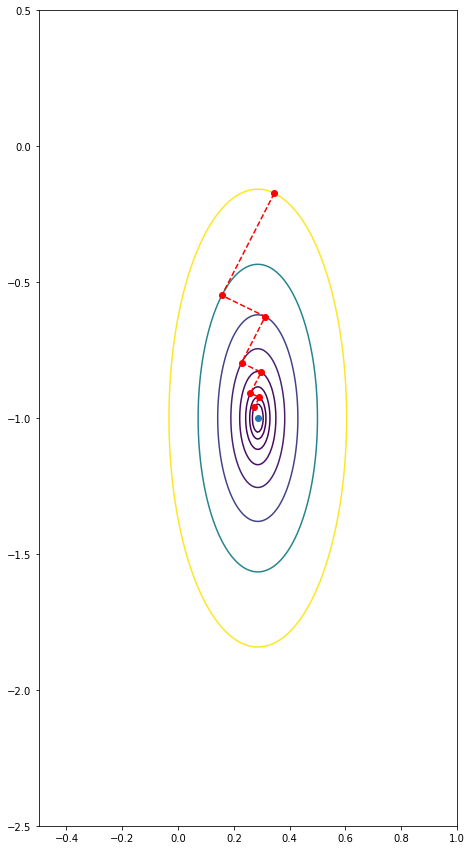

In [14]:
xk=optimal_step_gradient(a1,b1) 
show_level_set(a1, b1, xk, xexa1,nlevel=8)

L'algorithme du pas optimal permet de faire gagner 14 itérations par rapport au cas du pas fixe.

### Exemple 2

**Utiliser l'algorithme du gradient à pas optimal pour résoudre le système de l'Exemple 2 avec $N=4$, puis $N=64$. Observer le taux de convergence, et comparer avec le résultat de l'exercice précédent. On pourra afficher l'erreur après l'itération $k+1$ en fonction de l'erreur après l'itération $k$. Observer également la solution obtenue après $10^3$ itérations, et l'erreur avec la solution théorique. Commenter.**

In [26]:
    # N=4
xk=optimal_step_gradient(a22, b22)
print("Pour une matrice de taille 4 :")
show_results2(norme_a2,xk,xexa22,leg="top_right")
        

    # N=64
c=[]
sleep(2)
t1=time()
xk=optimal_step_gradient(a21, b21)
t2=time()

c.append(t2-t1)

print("Pour une matrice de taille 64 :")
c.append(show_results2(norme_a1,xk,xexa21,rg_erreur=9000))
        
carac.append(c)

Pour une matrice de taille 4 :
La borne théorique du taux de convergence est environ:  0.98309

la convergence a lieu en  62 itérations vers  [-0.00934398 -0.01836797 -0.02483197 -0.02265598] .

L'erreur finale est:  0.002055288582533263 .


Pour une matrice de taille 64 :
La borne théorique du taux de convergence est environ:  0.99998

la convergence a lieu en  10000 itérations vers  [-0.00076892 -0.00153783 -0.00230674 -0.00307563 -0.00384446 -0.00461319
 -0.00538172 -0.00614997 -0.00691777 -0.00768494 -0.00845125 -0.00921642
 -0.00998009 -0.01074187 -0.01150129 -0.0122578  -0.01301078 -0.01375953
 -0.01450325 -0.01524105 -0.01597197 -0.0166949  -0.01740866 -0.01811193
 -0.01880329 -0.01948118 -0.02014392 -0.0207897  -0.02141656 -0.0220224
 -0.02260497 -0.02316187 -0.02369053 -0.02418821 -0.02465202 -0.02507888
 -0.02546553 -0.02580853 -0.02610423 -0.02634881 -0.02653823 -0.02666825
 -0.02673442 -0.02673207 -0.0266563  -0.02650199 -0.0262638  -0.02593612
 -0.02551314 -0.02498875 -0.02435664 -0.0236102  -0.02274257 -0.02174664
 -0.020615   -0.01933996 -0.01791357 -0.01632758 -0.01457342 -0.01264226
 -0.01052493 -0.00821199 -0.00569364 -0.00295978] .

L'erreur finale est:  4.506167312820414e-05 .


On remarque qu'on a le même taux de convergence théorique que précédemment. Cependant, comme on calcul à chaque itération le pas optimal on arrive à gagner en précision sur les deux cas. Pour $N=4$, on arrive même à vérifier le critère de précision sur $\|Ax_k-b\|$ en 62 itérations.

## Gradient conjugué

**Ecrire une fonction qui implémente l'algorithme du gradient conjugué en prenant comme argument la matrice A, le vecteur b, le nombre maximal d'itérations, une tolérance sur l'erreur et retournant le tableau d'itérés de la méthode.**

In [16]:
def conjugate_gradient(a, b, nit_max=10000, eps=1.e-6):
    # initialisations
    xk=[] # tableau d'itérés
    k=0
    n=len(b)
    x=np.zeros(n)
    err=eps+1 # erreur
    
    # on calcul dès à présent le produit ab:
        #ab=np.dot(a,b)
    
    dk=b # x0=0
    gk=-b
    
    while (k<nit_max and err>eps):
        adk=csc_matrix.dot(a,dk)
        gamma=np.vdot(dk,gk)/(np.vdot(dk,adk))
                                     
        # calcul de xk+1            
        x=x-gamma*dk
        
        xk.append(x) # nécessaire car la première fonction prend des vecteurs ligne.
        
        # itération de l'erreur et de k
        k=k+1
                                     
        # calcul de la nouvelle direction:
        gk=csr_matrix.dot(a,x)-b
        betak=np.vdot(gk,adk)/(np.vdot(dk,adk))
        
        dk=-gk+np.dot(betak,dk)
        
        err=np.linalg.norm(gk)
                                 
    return np.array(xk)

### Exemple 1

**Utiliser l'algorithme du gradient conjugué pour résoudre le système de l'Exemple 1. Tracer les lignes de niveaux de la fonction $f$, ainsi que les différents itérés obtenus.**

la convergence a lieu en  2 itérations vers  [ 0.28571429 -1.        ] .


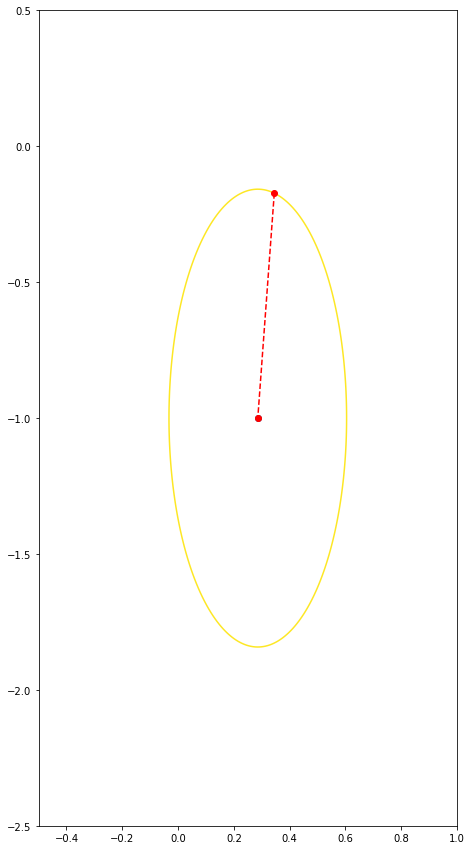

In [17]:
xk=conjugate_gradient(a1,b1) 
show_level_set(a1, b1, xk, xexa1,nlevel=8)

On convergence en deux itérations (i.e on fixe $x_0$ et on calcul le suivant qui vérifie nos conditions de précisions).

### Exemple 2

**Utiliser l'algorithme du gradient conjugué pour résoudre le système de l'Exemple 2 avec $N=4$, puis $N=64$. Observer qu'il converge en au plus $N$ itérations. On pourra légèrement modifier le critère d'arrêt.**

In [18]:
    # N=4
xk=conjugate_gradient(a22, b22)


print("Pour une matrice de taille 4 :")
show_results2(norme_a2,xk,xexa22,leg="top_right",power_conv=2)
        

    # N=64
c=[]
sleep(2)
t1=time()
xk=conjugate_gradient(a21, b21)
t2=time()

c.append(t2-t1)

print("Pour une matrice de taille 64 :")
c.append(show_results2(norme_a1,xk,xexa21,leg="top_right",power_conv=2))
        
carac.append(c)

Pour une matrice de taille 4 :
La borne théorique du taux de convergence est environ:  0.83092

la convergence a lieu en  4 itérations vers  [-0.009344 -0.018368 -0.024832 -0.022656] .

L'erreur finale est:  0.0020552372125864082 .


Pour une matrice de taille 64 :
La borne théorique du taux de convergence est environ:  0.99306

la convergence a lieu en  64 itérations vers  [-0.00076893 -0.00153785 -0.00230677 -0.00307567 -0.00384451 -0.00461324
 -0.00538179 -0.00615004 -0.00691785 -0.00768504 -0.00845136 -0.00921653
 -0.00998021 -0.010742   -0.01150143 -0.01225795 -0.01301093 -0.01375968
 -0.01450341 -0.01524122 -0.01597214 -0.01669508 -0.01740884 -0.01811212
 -0.01880348 -0.01948137 -0.02014412 -0.0207899  -0.02141676 -0.02202261
 -0.02260518 -0.02316208 -0.02369073 -0.02418842 -0.02465223 -0.02507909
 -0.02546573 -0.02580873 -0.02610443 -0.026349   -0.02653842 -0.02666844
 -0.0267346  -0.02673224 -0.02665647 -0.02650216 -0.02626396 -0.02593628
 -0.02551328 -0.02498889 -0.02435677 -0.02361032 -0.02274269 -0.02174675
 -0.02061509 -0.01934005 -0.01791365 -0.01632764 -0.01457348 -0.01264231
 -0.01052497 -0.00821202 -0.00569366 -0.00295979] .

L'erreur finale est:  4.389338223376162e-05 .


# Conclusion:

In [19]:
print("Pour l'exemple 2, nous avons : ")
print("")
print("Gradient constant:")
print("Temps de résolution pur : ", carac[0][0], "secondes  ;  Nombre d'itérations: ", carac[0][1][0],"  ;   erreur finale :", carac[0][1][1], "  ;  taux de convergence moyen: ", carac[0][1][2])

print("")

print("Gradient optimal:")
print("Temps de résolution pur : ", carac[1][0], "secondes  ;  Nombre d'itérations: ", carac[1][1][0]," ;  erreur finale :", carac[1][1][1], "  ;  taux de convergence moyen: ", carac[1][1][2])

print("")

print("Gradient conjugué:")
print("Temps de résolution pur : ", carac[2][0], "secondes  ;  Nombre d'itérations: ", carac[2][1][0],"  ;  erreur finale :", carac[2][1][1], "  ;  taux de convergence moyen: ", carac[2][1][2])

Pour l'exemple 2, nous avons : 

Gradient constant:
Temps de résolution pur :  0.17157626152038574 secondes  ;  Nombre d'itérations:  10000   ;   erreur finale : 0.00043684116343040884   ;  taux de convergence moyen:  0.9994163409543989

Gradient optimal:
Temps de résolution pur :  0.23407196998596191 secondes  ;  Nombre d'itérations:  10000  ;  erreur finale : 4.506167312820414e-05   ;  taux de convergence moyen:  0.9991920975482445

Gradient conjugué:
Temps de résolution pur :  0.0 secondes  ;  Nombre d'itérations:  64   ;  erreur finale : 4.389338223376162e-05   ;  taux de convergence moyen:  0.8810012593300987


#### En conclusion: quelques remarques additionnelles sur le résumé qui précède.
<ul>
<li> Comme la norme 2 de la matrice augmente avec sa taille (dans le cas Laplacien), son conditionnement augmente également et par conséquent le majorant du taux de convergence, qu'on a calculé théoriquement, se rapproche de 1. 
<li> En étudiant les taux de convergence moyen empirique, on voit que la méthode du gradient conjugué est bien meilleure (cf. ce qui précède).
<li> Le temps de résolution du gradient optimal pour la matrice du Laplacien avec $N=64$ est 2 fois supérieur à celui du gradient constant. En effet, le calcul du pas optimal à chaque itérations est lourd en calculs. On échange davantage de précision contre plus de temps de calculs. Pour le gradient conjugué, la convergence se faisant en peu d'itérations, le temps de résolution apparaît très faible (on obtient 0 sec...). 
</ul>